# Capstone: Airbnb Price Listing Prediction
## Part 3 Feature Engineering & Model Benchmark

_Authors: Evonne Tham_

In this notebook, the goal will be to use the insights garnered from EDA to create a feature-selected and finetuned model that will perform well on generalized, unseen data.

But before that model preparation will be carried out by one-hot encoding and producing dummy variables for categorical features, after which, I will go through the modelling process as per below:

- Split the data into train, test, and validation.
- Train as many models as there are hyperparameter combinations on the train set.
- Evaluate each of these models on the validation set.

Workflow source: https://github.com/esentri/datascience_blog_resources/blob/master/model_selection.ipynb


## Contents of this notebook
- [1. Import Necessary Libraries and Load Data](#1.-Import-Necessary-Libraries-and-Load-Data)
- [2. Feature Engineering](#2.-Feature-Engineering)
    - [2.1. Categorical Variables](#2.1.-Categorical-Variables)
    - [2.2.Amenities](#2.2.-Amenities)
- [3. Model Prep](#3.-Model-Prep) 
- [4. Modelling](#4.-Modelling)


## 1. Import Necessary Libraries and Load Data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Please also type in the following command line/terminal installations**:

- `brew install libomp`
- `pip install xgboost`

In [2]:
# Load in Data 
df = pd.read_csv('../datasets/final_df.csv')

#Set id as index 
df.set_index('id', inplace=True)

print(f"Total Number of Listing: {df.shape[0]} | Total Number of Features: {df.shape[1]}")
df.head(4).T

Total Number of Listing: 13487 | Total Number of Features: 43


id,35303,197677,289597,370759
host_id,151977,964081,341577,1573631
host_since,2010-06-25,2011-08-13,2011-01-10,2012-01-06
host_response_time,unknown,within a few hours,within a few hours,within a day
host_response_rate,unknown,100%,100%,100%
host_acceptance_rate,unknown,50-89%,50-89%,90-99%
host_is_superhost,0,1,0,1
host_listings_count,3,1,2,3
host_identity_verified,1,1,1,1
neighbourhood,Shibuya Ku,Sumida Ku,Nerima Ku,Setagaya Ku
country_code,JP,JP,JP,JP


---
<a id=’feature_engineering’></a>
## 2. Feature Engineering 

Categorical variables will be converted here into a form that could be provided to ML algorithms to do a better job in prediction through one-hot encoding. Furthermore the column containing Amenities will be separated via get dummies as well. 

##### 2.1. Categorical Variables

In [3]:
df_dummies = pd.get_dummies(df, columns=['property_type',
                                 'room_type',
                                 'cancellation_policy',
                                 'neighbourhood',
                                 'host_response_time',
                                 'host_acceptance_rate',
                                 'review_scores_rating',
                                 'review_scores_accuracy',
                                 'review_scores_cleanliness',
                                 'review_scores_checkin',
                                 'review_scores_communication',
                                 'review_scores_location',
                                 'review_scores_value',
                                 'instant_bookable',
                                 'is_location_exact'
                                ], 
                         drop_first = False)

##### 2.2. Amenities

In [4]:
all_amenities = df_dummies['amenities'].str.get_dummies(sep=',')
df_dummies = pd.concat([df_dummies, all_amenities], axis=1)

print(f"Total Number of Listing: {df_dummies.shape[0]} | Total Number of Features: {df_dummies.shape[1]}")

Total Number of Listing: 13487 | Total Number of Features: 300


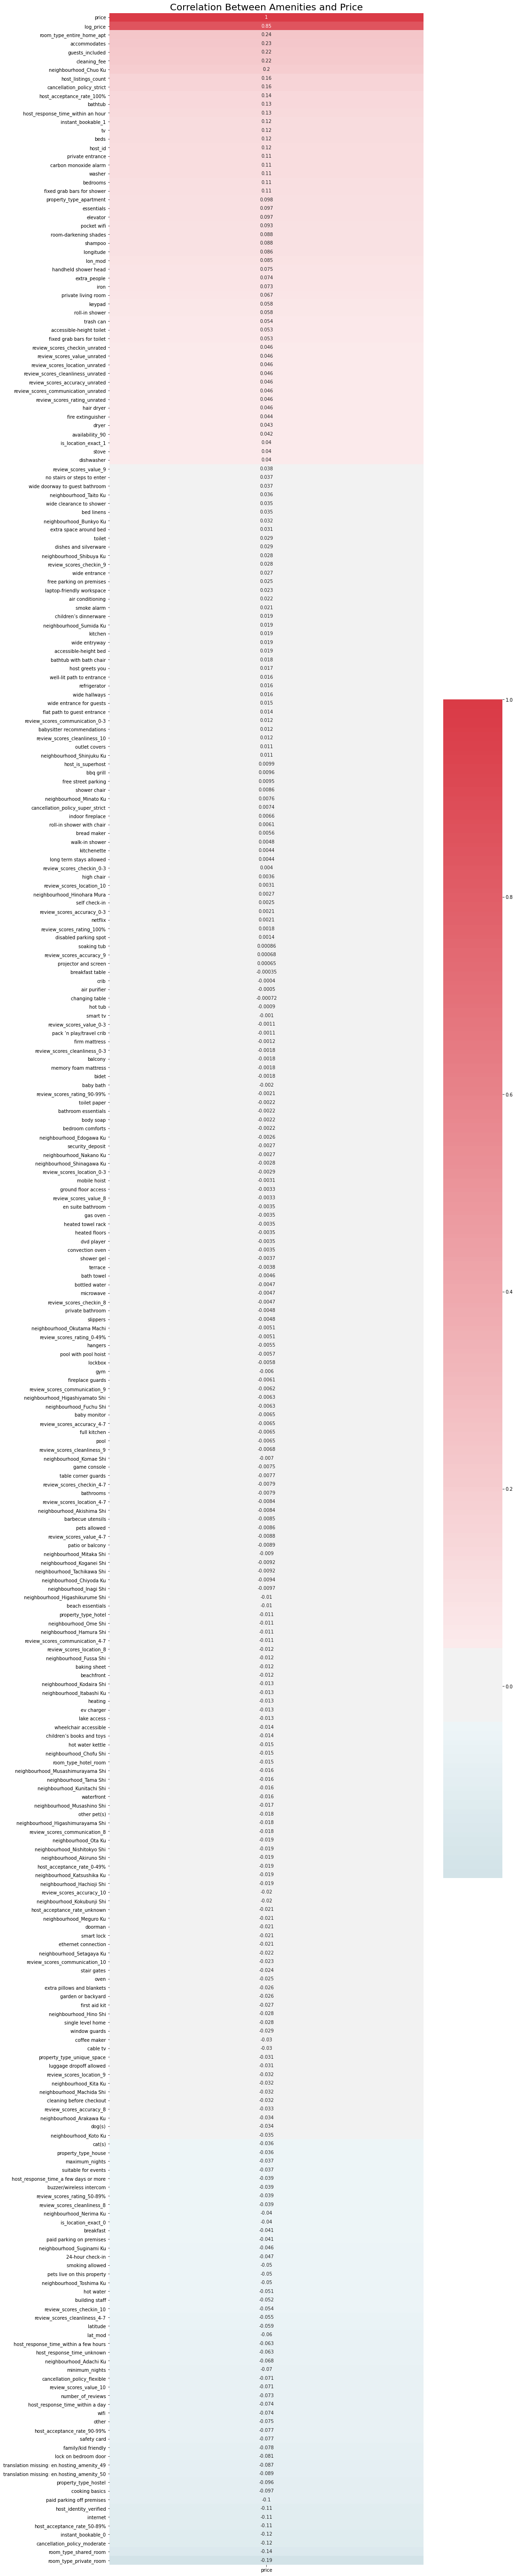

In [5]:
fig = plt.figure(figsize=(15,100))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr()

sns.heatmap(df_dummies.corr()[['price']].sort_values(by='price', ascending=False), 
            cmap=cmap, 
            center=0, 
            annot=True,
            cbar_kws={"shrink": .9},)

plt.title('Correlation Between Amenities and Price', fontsize=20);

So far, after encoding the various variables with numerical data, the heatmap shows a good range of variables and their respective correlation. There appears to be a few slightly significant variables such as `room_type_entire_room_apt`,`accomodates`,`guests_included`, `cleaning_fee` and `rome_type_private_room`. This is good for the modelling, as it would be useful to find out variables that may negatively affect Sale Price.


In [6]:
# # Grouping Amenities
# all_amenities["essential_amenities"] = (all_amenities[" toilet"] + 
#                                         all_amenities["bed linens"])

# all_amenities["extra_amenities"] = (all_amenities["24-hour check-in"] + 
#                                     all_amenities["breakfast"])

# all_amenities["luxury_amenities"] = (all_amenities["air conditioning"] + 
#                                      all_amenities["netflix"] + 
#                                      all_amenities["smart tv"]+
#                                      all_amenities["wifi"]+
#                                      all_amenities["dvd player"]+
#                                      all_amenities["game console"])
# all_amenities

---
##  3. Model Prep

In [7]:
# Split Dataset into train and test set
train, test = train_test_split(df_dummies, test_size=0.2)

In [8]:
# Save test set for production model
test.to_csv('../datasets/test.csv')

### i. Create X and y variables

In [9]:
features = [col for col in train._get_numeric_data().columns if col != 'price' and col != 'id' and col != 'host_id']

X = train[features]
y = train['price']

###  ii. Baseline Prediction 

In [10]:
print(f'The mean value of the target vector is: {np.mean(y)}.')

The mean value of the target vector is: 18407.69904532394.


Without any regression modelling, the predicted value for every data point is 17990¥.

### iii. Train/ Validation Splits

In [11]:
# Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

### iv. Baseline score

In [12]:
dummy_constant = DummyRegressor(strategy='constant', constant = 17990.367118495848 )
dummy_constant.fit(X_train, y_train)
print(f'R2 score for baseline model: {dummy_constant.score(X_train, y_train)}.')

R2 score for baseline model: -0.00033118324568004454.


This is a bad $R^2$ score as it indicates that the baseline model explains basically none of the variability of the response data around its mean.

---
## 4. Modelling

This function will return the the train accuracy score, validation accuracy score, grid search score, best paramaters, $R^2$ score, MSE and RMSE which will then use this to evaluate our metrics against the validation set.

The 4 models that I will be using in this regression problem are:

- Linear Regression
    - The most basic form, where the model is not penalized for its choice of weights [[1]](https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29)
- ElasticNet
    - The hybrid of Lasso and Ridge, where both the absolute value penalization and squared penalization are included, being regulated with another coefficient l1_ratio [[1]](https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29)
- Support Vector Machine Regressor
    - It uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal boundary between the possible outputs. [[2]](https://community.alteryx.com/t5/Data-Science/Why-use-SVM/ba-p/138440#:~:text=SVM%20is%20a%20supervised%20machine,boundary%20between%20the%20possible%20outputs.)
- XGBoosting Classifier 
    - A scalable and accurate implementation of gradient boosting machines and it has proven to push the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed. [[2]](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html#:~:text=XGBoost%20is%20a%20scalable%20and,model%20performance%20and%20computational%20speed.)


On top of that RobustScaler will be used to standardize the data's scaling. This is because there is a fair number of outliers in the distributions that were already explored in the EDA notebook. Robust Scaler is so named because it handles outliers better.

In [13]:
# Scale the data
rs = RobustScaler()
rs.fit(X_train)
X_train_rs = rs.transform(X_train)
X_val_rs = rs.transform(X_val)

# Model instantiation
lr = LinearRegression()
enet = ElasticNetCV()
svr = SVR()
xgb = XGBRegressor()

# Run the different models and compare
lr_model = lr.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(lr, X_train_rs, y_train, cv=5).mean()))
print("LR score on training set with default parameters: {}". format(lr_model.score(X_train_rs, y_train)))
print("LR score on validation set with default parameters: {}". format(lr_model.score(X_val_rs, y_val)))
print("==============================================================================")

enet_model = enet.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(enet, X_train_rs, y_train, cv=5).mean()))
print("ENET score on training set with default parameters: {}". format(enet_model.score(X_train_rs, y_train)))
print("ENET score on validation set with default parameters: {}". format(enet_model.score(X_val_rs, y_val)))
print("==============================================================================")

svr_model = svr.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(svr, X_train_rs, y_train, cv=5).mean()))
print("SVR score on training set with default parameters: {}". format(svr_model.score(X_train_rs, y_train)))
print("SVR score on validation set with default parameters: {}". format(svr_model.score(X_val_rs, y_val)))
print("==============================================================================")

xgb_model = xgb.fit(X_train_rs, y_train)
print("Accuracy of Model with Cross-Validation: {}".format(cross_val_score(xgb, X_train_rs, y_train, cv=5).mean()))
print("XGBoost score on training set with default parameters: {}". format(xgb_model.score(X_train_rs, y_train)))
print("XGBoost score on validation set with default parameters: {}". format(xgb_model.score(X_val_rs, y_val)))

Accuracy of Model with Cross-Validation: -2042392886919228.8
LR score on training set with default parameters: 0.8304162951533846
LR score on validation set with default parameters: -326675335.9405076
Accuracy of Model with Cross-Validation: 0.09693579451424716
ENET score on training set with default parameters: 0.09854559091776416
ENET score on validation set with default parameters: 0.10243220417012333
Accuracy of Model with Cross-Validation: -0.1187540794132786
SVR score on training set with default parameters: -0.11847715589156516
SVR score on validation set with default parameters: -0.12828059253704494
Accuracy of Model with Cross-Validation: 0.9999674217784303
XGBoost score on training set with default parameters: 0.9999995551816451
XGBoost score on validation set with default parameters: 0.9999856744968662


By comparing these models, 3 out of 4 performed pretty badly, especially for linear regression which performed the worst which is as expected. However, what is not expected is that XGBoost performed oddly well here. Nevertheless, lets see how much we can improve with hyperparameter tuning

##### Save Final Dataframe

In [14]:
train.to_csv('../datasets/train.csv')

----> Proceed to the next notebook for [Model Tuning](./04_Model_Tuning.ipynb)